In [1]:
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests

dict_names = [
    "nn",
    "gnn",
    "gnn_transformer",
    "coevosg",
    "random"
]

full_names = [
    "Feed-Forward Neural Network",
    "Graph Neural Network",
    "Graph Neural Network with Transformer",
    "CoevoSG",
    "random",
]

def read_data(file_path):
    with open(file_path, "r") as f:
        data = yaml.safe_load(f)
    return data

sns.set(style="whitegrid")
def plot_density(data, tit="density"):
    results = [get_data(data, key) for key in dict_names]
    plt.figure(figsize=(10, 6))
    for result, title in zip(results, full_names):
        sns.kdeplot(data=result, fill=True, label=title)
    plt.title(tit)
    plt.xlabel("Reward")
    plt.ylabel("Density")
    plt.legend()
    #plt.xlim(-1, 1)
    #plt.ylim(0, 5)
    plt.grid()
    plt.savefig(f"{tit}.png", dpi=300)
    plt.show()
    
def get_data(results, key):
    out = []
    for k in results:
        if k.startswith(f"{key}/") and k.endswith("/raw"):
            out.extend(results[k])
    return out

def get_data_specific(results, key1, key2):
    out = []
    for k in results:
        if k.startswith(f"{key1}/{key2}/") and k.endswith("/raw"):
            out.extend(results[k])
    return out

def compare_models(results, model1, model2, print_results=False):
    data1 = get_data(results, model1)
    data2 = get_data(results, model2)
    
    if len(data1) != len(data2):
        raise ValueError("Data lengths do not match for comparison.")
    
    stat, p_value = wilcoxon(np.array(data1) - np.array(data2), alternative="greater")
    if print_results:
        print(f"Wilcoxon test between {model1} and {model2}: statistic={stat:.3f}, p-value={p_value:.3f}")
        
        if p_value < 0.05:
            print(f"Result: {model1} is statistically significantly better than {model2}.")
        else:
            print(f"Result: {model1} is not statistically significantly better than {model2}.")
        
    return p_value

def holm_bonferroni_correction(p_values):
    corrected = multipletests(p_values, method='holm')
    return corrected[1]  # Return the corrected p-values
    
def compare_many_models(results, compared_model, print_results=False):
    models_to_compare = dict_names
    models_without_the_model = [model for model in models_to_compare if model != compared_model]
    p_values = [compare_models(results, compared_model, model, print_results=False) for model in models_without_the_model]

    corrected_p_values = holm_bonferroni_correction(p_values) 
    output = {}
    if print_results:
        print(f"{compared_model} vs others p-values:")
    for model, p_value, org_p_value in zip(models_without_the_model, corrected_p_values, p_values):
        output[model] = {"p_value": p_value, "org_p_value": org_p_value}
        if print_results:
            print(f"{model}: {p_value:.5f}({org_p_value:.5f}) - {'Significantly' if p_value < 0.05 else 'Not significantly'} better")
    return output

def compare_all_models(results, print_results=False):
    all_results = {}
    for model in dict_names:
        all_results[model] = compare_many_models(results, model, print_results=False)
    # print results as table
    if print_results:
        print(f"{'Model':<30} {'Compared Model':<30} {'Corrected p-value':<20} {'Original p-value':<20} {'Significance':<15}")
        for model in dict_names:
            for compared_model, values in all_results[model].items():
                significance = 'Significantly' if values['p_value'] < 0.05 else 'Not significantly'
                print(f"{model:<30} {compared_model:<30} {values['p_value']:<20.5f} {values['org_p_value']:<20.5f} {significance:<15}")
    return all_results

def get_summarized_results_for_all_models(data, print_results=False):
    out = {}
    for model in dict_names:
        model_data = get_data(data, model)
        mean = np.mean(model_data)
        std = np.std(model_data)
        out[model] = {"mean": mean, "std": std, "n": len(model_data)}
    # print results as table
    if print_results:
        print(f"{'Model':<30} {'Mean':<10} {'Std':<10} {'N':<10}")
        for model in dict_names:
            print(f"{model:<30} {out[model]['mean']:<10.4f} {out[model]['std']:<10.4f} {out[model]['n']:<10}")
    return out

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def normalize(data, min_val, max_val):
    for key in data:
        for k in data[key]:
            if k in ["mean", "std"]:
                data[key][k] = (data[key][k] - min_val) / (max_val - min_val)
                
    return data

def visualize_significance(
    p_value_data: dict,
    title: str,
    alpha: float = 0.05,
    key: str = 'p_value',
    output_filename: str = 'significance_matrix.png'
):
    """
    Visualizes significance levels from a nested dictionary as a minimalistic
    colored matrix.

    Blue: Significant (p <= alpha)
    Red: Not Significant (p > alpha)
    Diagonal is left empty.

    Args:
        p_value_data (dict): A nested dictionary with p-values.
        alpha (float): The significance level threshold. Defaults to 0.05.
        key (str): The key to access the p-value ('p_value' or 'org_p_value').
                   Defaults to 'p_value'.
        output_filename (str): The path to save the output figure.
    """
    # Get the sorted list of model names for consistent ordering
    labels = sorted(p_value_data.keys())
    n = len(labels)
    
    # Create an empty matrix to store significance flags
    # 0 = significant, 1 = not significant, NaN = diagonal
    significance_matrix = np.full((n, n), np.nan)

    for i, row_label in enumerate(labels):
        for j, col_label in enumerate(labels):
            if i == j:
                continue  # Keep diagonal as NaN
            
            p_val = p_value_data[row_label][col_label][key]
            
            # 0 for significant, 1 for not significant
            significance_matrix[i, j] = 0 if p_val <= alpha else 1

    # Create a DataFrame for easier plotting with labels
    df = pd.DataFrame(significance_matrix, index=labels, columns=labels)

    # --- Plotting ---
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(7, 6))

    # Custom colormap: blue for 0 (significant), red for 1 (not significant)
    cmap = ListedColormap(['#0077b6', '#d62828'])

    sns.heatmap(
        df,
        cmap=cmap,
        linewidths=2,
        linecolor='white',
        cbar=False,  # Hide the color bar for a minimalistic look
        square=True,
        ax=ax
    )

    # Improve aesthetics
    ax.set_title(f'{title}', fontsize=16, pad=20)
    ax.tick_params(axis='both', which='major', labelsize=12, length=0)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    output_filename = f'significance_matrix{title.lower().replace(" ", "_")}.png'
    # Save and show the plot
    plt.tight_layout()
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"Figure saved to '{output_filename}'")
    plt.show()

In [3]:
values = []
steps = []

Model                          Mean       Std        N         
nn                             22.5457    1.8308     600       
gnn                            22.5480    1.8315     600       
gnn_transformer                22.5479    1.8209     600       
coevosg                        22.0460    1.5359     600       
random                         21.7025    1.8797     600       
Model                          Compared Model                 Corrected p-value    Original p-value     Significance   
nn                             gnn                            0.65692              0.54341              Not significantly
nn                             gnn_transformer                0.65692              0.32846              Not significantly
nn                             coevosg                        0.00000              0.00000              Significantly  
nn                             random                         0.00000              0.00000              Significantly  
gnn         

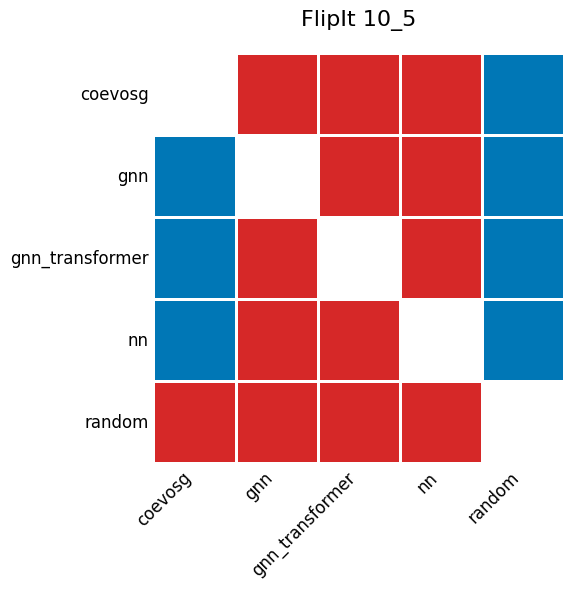

In [4]:
steps.append("10_5")
flipit_10 = read_data("stackelberg/test_flipit_10_5_41.yaml")
results = normalize(get_summarized_results_for_all_models(flipit_10, print_results=True), -3.9304, 25.3271)
values.append(results)
significance = compare_all_models(flipit_10, print_results=True)
visualize_significance(significance, 'FlipIt 10_5')

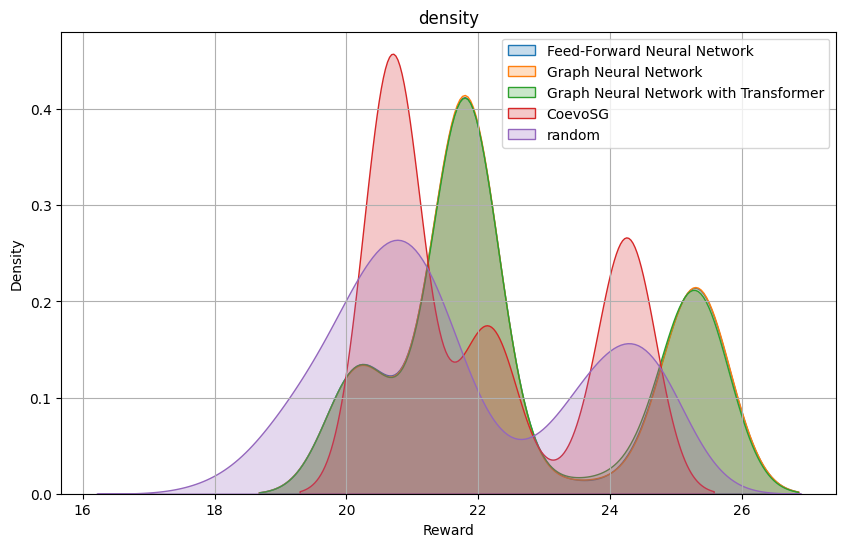

In [5]:
plot_density(flipit_10)

Model                          Mean       Std        N         
nn                             83.4494    14.4556    600       
gnn                            90.6700    10.4487    600       
gnn_transformer                88.2763    12.0504    600       
coevosg                        84.3768    14.3477    600       
random                         85.2194    14.7907    600       
Model                          Compared Model                 Corrected p-value    Original p-value     Significance   
nn                             gnn                            1.00000              1.00000              Not significantly
nn                             gnn_transformer                1.00000              1.00000              Not significantly
nn                             coevosg                        1.00000              1.00000              Not significantly
nn                             random                         1.00000              1.00000              Not significantly
gnn     

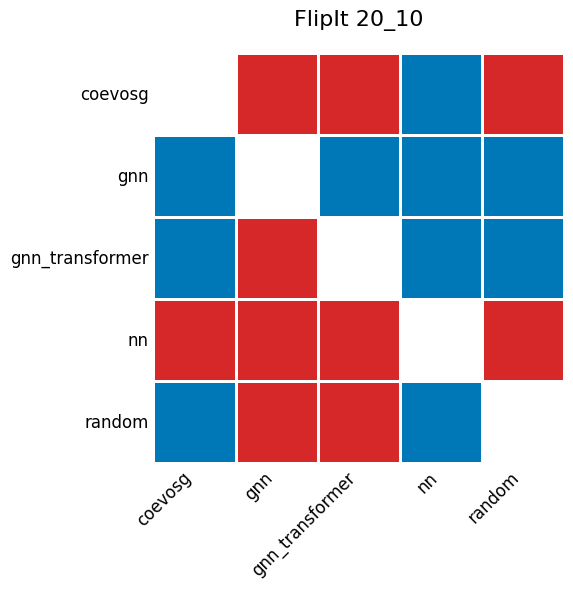

In [6]:
steps.append("20_10")
flipit_20 = read_data("stackelberg/test_flipit_20_10_41.yaml")
results = normalize(get_summarized_results_for_all_models(flipit_20, print_results=True), -9.3606, 105.1840)
values.append(results)
significance = compare_all_models(flipit_20, print_results=True)
visualize_significance(significance, 'FlipIt 20_10')

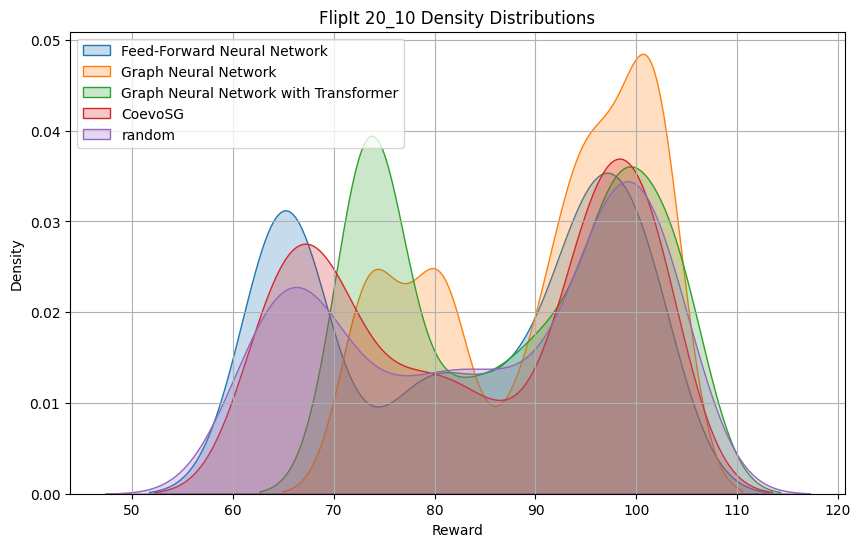

In [7]:
plot_density(flipit_20, tit="FlipIt 20_10 Density Distributions")

Model                          Mean       Std        N         
nn                             185.0602   47.3779    600       
gnn                            178.3984   38.5572    600       
gnn_transformer                208.5408   24.9929    600       
coevosg                        182.4252   46.1356    600       
random                         185.6178   43.2130    600       
Model                          Compared Model                 Corrected p-value    Original p-value     Significance   
nn                             gnn                            0.00000              0.00000              Significantly  
nn                             gnn_transformer                1.00000              1.00000              Not significantly
nn                             coevosg                        0.00000              0.00000              Significantly  
nn                             random                         0.07759              0.03879              Not significantly
gnn         

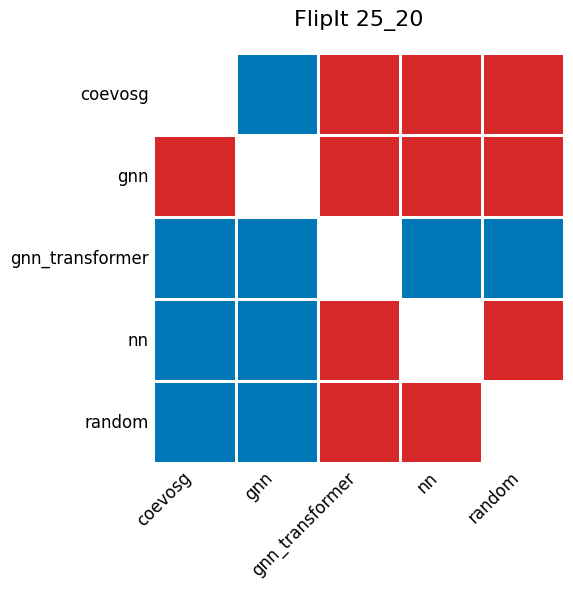

In [8]:
steps.append("25_20")
flipit_25 = read_data("stackelberg/test_flipit_25_20_41.yaml")
results = normalize(get_summarized_results_for_all_models(flipit_25, print_results=True), -19.9125, 234.4127)
values.append(results)
significance = compare_all_models(flipit_25, print_results=True)
visualize_significance(significance, 'FlipIt 25_20')

Model                          Mean       Std        N         
nn                             476.7599   31.5654    600       
gnn                            403.5165   110.3267   600       
gnn_transformer                482.3656   38.0310    600       
coevosg                        413.0230   98.5386    600       
random                         406.4234   104.0365   600       
Model                          Compared Model                 Corrected p-value    Original p-value     Significance   
nn                             gnn                            0.00000              0.00000              Significantly  
nn                             gnn_transformer                1.00000              1.00000              Not significantly
nn                             coevosg                        0.00000              0.00000              Significantly  
nn                             random                         0.00000              0.00000              Significantly  
gnn           

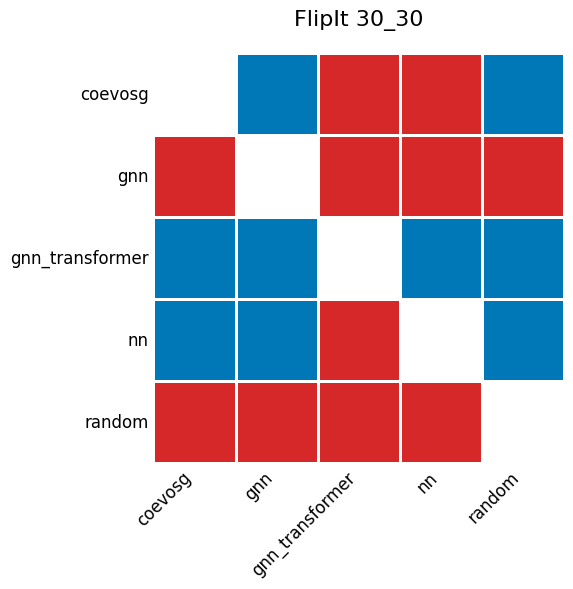

In [9]:
steps.append("30_30")
flipit_30 = read_data("stackelberg/test_flipit_30_30_41.yaml")
results = normalize(get_summarized_results_for_all_models(flipit_30, print_results=True), -29.4725, 514.8811)
values.append(results)
significance = compare_all_models(flipit_30, print_results=True)
visualize_significance(significance, 'FlipIt 30_30')

Model                          Mean       Std        N         
nn                             1046.5318  79.9952    600       
gnn                            979.5385   167.3614   600       
gnn_transformer                1049.8621  78.3315    600       
coevosg                        983.2796   158.9213   600       
random                         978.6039   158.2022   600       
Model                          Compared Model                 Corrected p-value    Original p-value     Significance   
nn                             gnn                            0.00000              0.00000              Significantly  
nn                             gnn_transformer                0.00004              0.00004              Significantly  
nn                             coevosg                        0.00000              0.00000              Significantly  
nn                             random                         0.00000              0.00000              Significantly  
gnn             

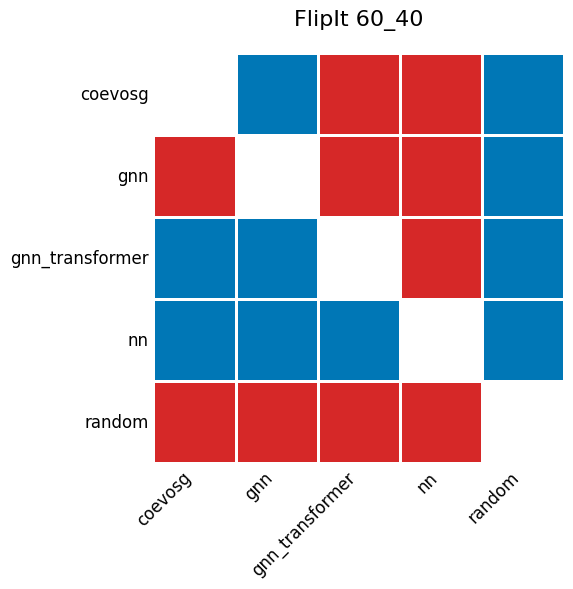

In [10]:
steps.append("60_40")
flipit_60 = read_data("stackelberg/test_flipit_60_40_41.yaml")
results = normalize(get_summarized_results_for_all_models(flipit_60, print_results=True), -39.9715, 1143.0746)
values.append(results)
significance = compare_all_models(flipit_60, print_results=True)
visualize_significance(significance, 'FlipIt 60_40')

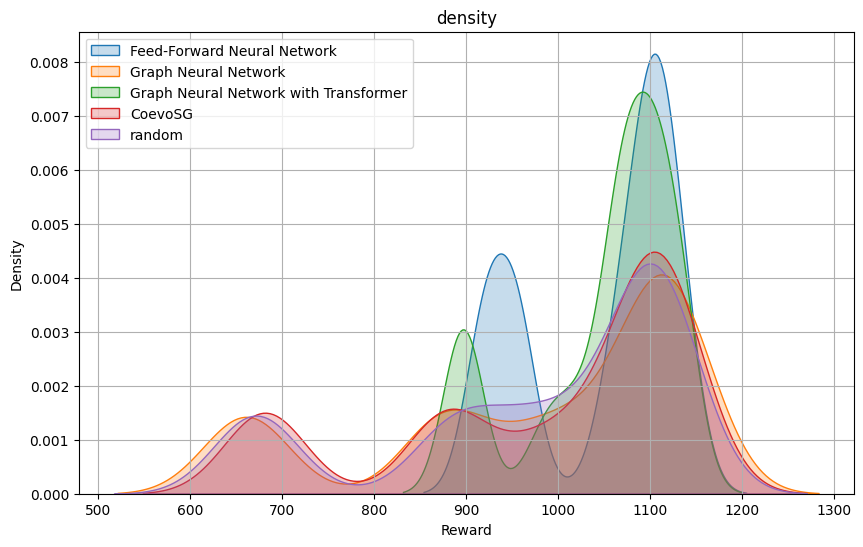

In [11]:
plot_density(flipit_60)

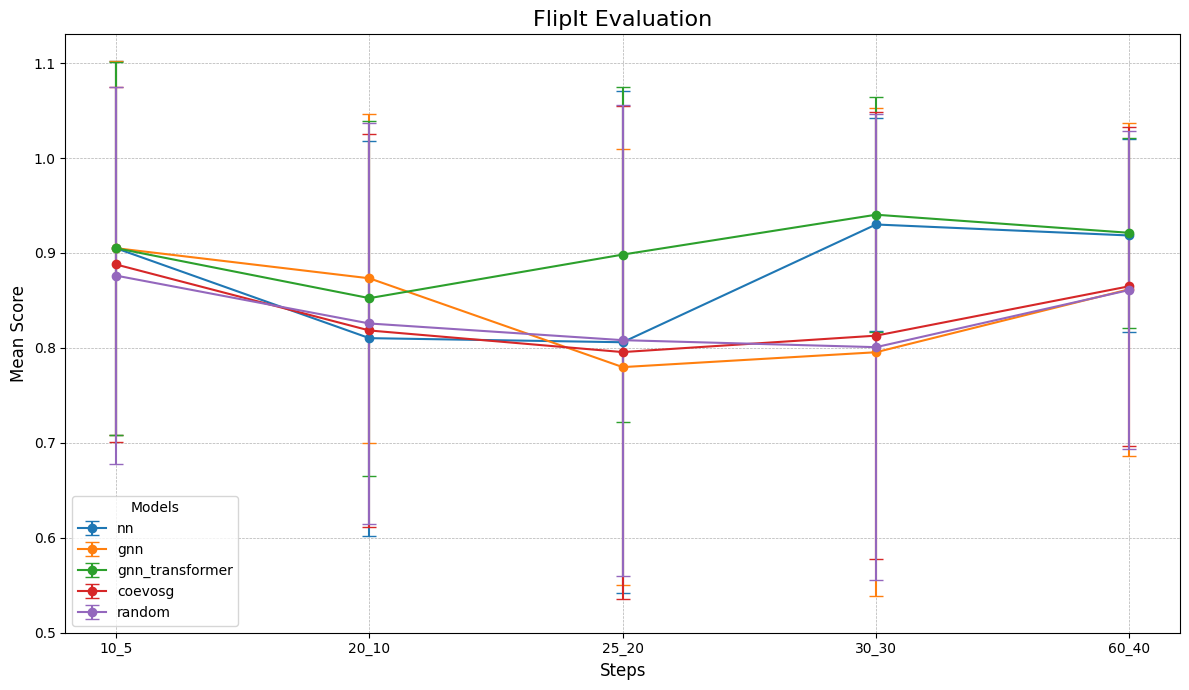

In [12]:
model_names = list(values[0].keys())
plot_data = {model: {'means': [], 'stds': []} for model in model_names}

for step_data in values:
    for model_name, stats in step_data.items():
        plot_data[model_name]['means'].append(stats['mean'])
        plot_data[model_name]['stds'].append(stats['std'])

# 3. Create the plot
fig, ax = plt.subplots(figsize=(12, 7))

# Plot each model's data using errorbar
for model_name, data in plot_data.items():
    means = np.array(data['means'])
    stds = np.array(data['stds'])
    
    # Use ax.errorbar to plot lines with vertical error bars
    ax.errorbar(
        steps,                  # X-axis values
        means,                  # Y-axis values (the mean)
        yerr=stds,              # The standard deviation for the vertical error bars
        label=model_name,       # Label for the legend
        marker='o',             # Style for the data points
        linestyle='-',          # Style for the connecting line
        capsize=5               # Adds the small horizontal bars to the error lines
    )

# 4. Customize and show the plot
ax.set_title('FlipIt Evaluation', fontsize=16)
ax.set_xlabel('Steps', fontsize=12)
ax.set_ylabel('Mean Score', fontsize=12)
ax.legend(title='Models')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylim(bottom=0.5) # Set a reasonable y-axis minimum
plt.tight_layout()
plt.savefig('flipit.png')
plt.show()

# Poachers

In [13]:
values = []
steps = []

Model                          Mean       Std        N         
nn                             3.3365     3.9471     600       
gnn                            1.1108     5.5421     600       
gnn_transformer                1.4323     5.5210     600       
coevosg                        1.4409     6.6117     600       
random                         -0.8874    6.4282     600       
Model                          Compared Model                 Corrected p-value    Original p-value     Significance   
nn                             gnn                            0.00000              0.00000              Significantly  
nn                             gnn_transformer                0.00000              0.00000              Significantly  
nn                             coevosg                        0.00097              0.00097              Significantly  
nn                             random                         0.00000              0.00000              Significantly  
gnn             

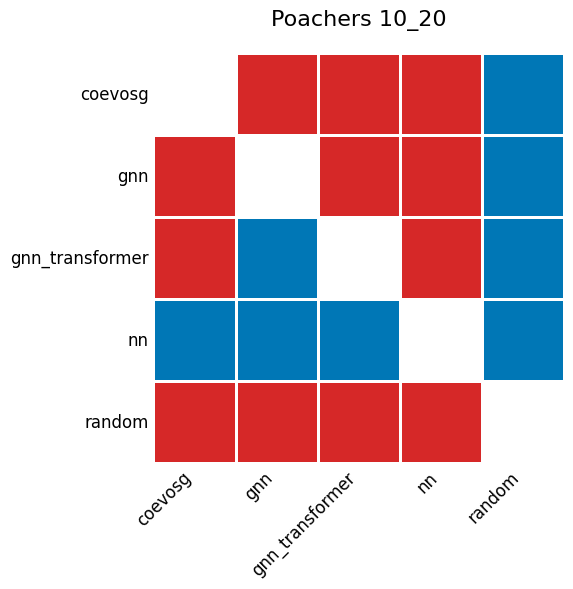

In [14]:
steps.append("10_20")
poachers_10 = read_data("stackelberg/test_poachers_10_20_41.yaml")
results = normalize(get_summarized_results_for_all_models(poachers_10, print_results=True), -10.5805, 10.5805)
values.append(results)
significance = compare_all_models(poachers_10, print_results=True)
visualize_significance(significance, 'Poachers 10_20')

Model                          Mean       Std        N         
nn                             3.3365     3.9471     600       
gnn                            1.1108     5.5421     600       
gnn_transformer                1.4323     5.5210     600       
coevosg                        1.4409     6.6117     600       
random                         -0.8874    6.4282     600       
Model                          Compared Model                 Corrected p-value    Original p-value     Significance   
nn                             gnn                            1.00000              0.97970              Not significantly
nn                             gnn_transformer                1.00000              0.52133              Not significantly
nn                             coevosg                        1.00000              1.00000              Not significantly
nn                             random                         0.00000              0.00000              Significantly  
gnn       

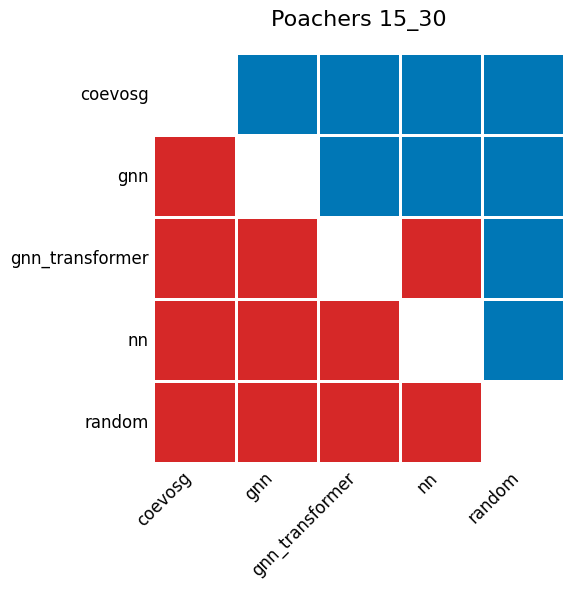

In [15]:
steps.append("15_30")
poachers_15 = read_data("stackelberg/test_poachers_15_30_41.yaml")
results = normalize(get_summarized_results_for_all_models(poachers_10, print_results=True), -14.4298, 14.4298)
values.append(results)
significance = compare_all_models(poachers_15, print_results=True)
visualize_significance(significance, 'Poachers 15_30')

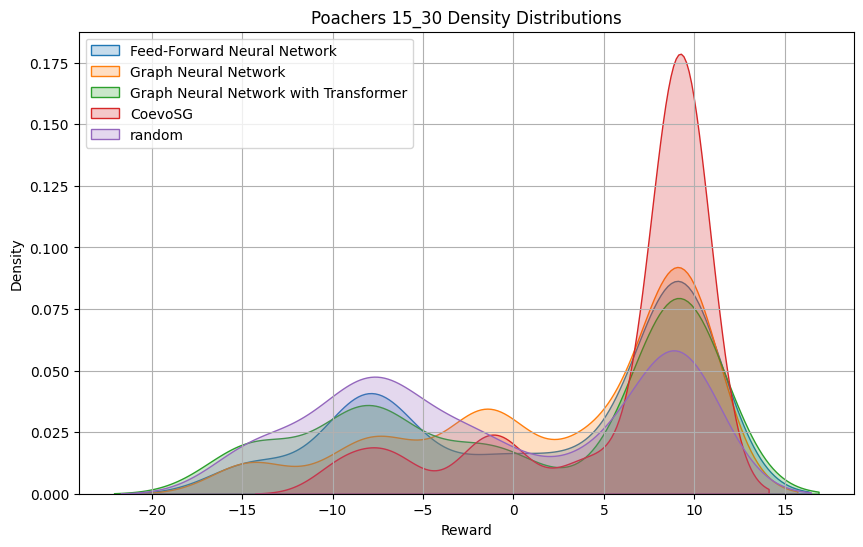

In [16]:
plot_density(poachers_15, "Poachers 15_30 Density Distributions")

Model                          Mean       Std        N         
nn                             5.1973     12.2767    600       
gnn                            3.7898     9.6357     600       
gnn_transformer                6.4494     12.4257    600       
coevosg                        3.1813     13.3369    600       
random                         1.0194     14.0292    600       
Model                          Compared Model                 Corrected p-value    Original p-value     Significance   
nn                             gnn                            0.02240              0.00747              Significantly  
nn                             gnn_transformer                0.99993              0.99993              Not significantly
nn                             coevosg                        0.02240              0.00761              Significantly  
nn                             random                         0.00000              0.00000              Significantly  
gnn           

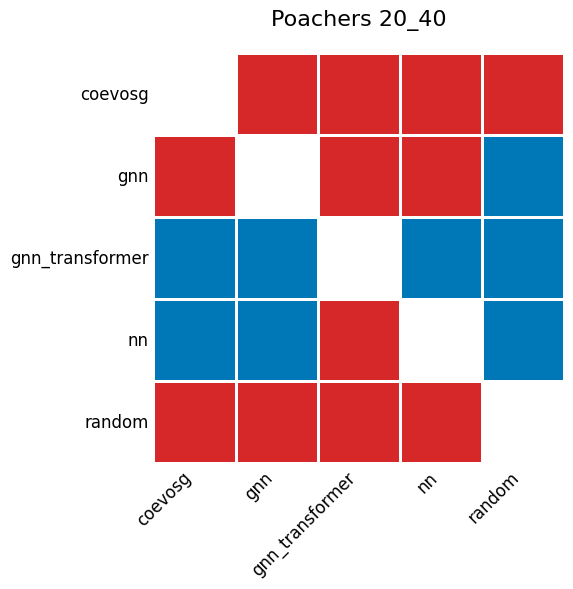

In [17]:
steps.append("20_40")
poachers_20 = read_data("stackelberg/test_poachers_20_40_41.yaml")
results = normalize(get_summarized_results_for_all_models(poachers_20, print_results=True), -29.1269, 29.1269)
values.append(results)
significance = compare_all_models(poachers_20, print_results=True)
visualize_significance(significance, 'Poachers 20_40')

Model                          Mean       Std        N         
nn                             2.0735     15.8966    600       
gnn                            2.7448     20.0263    600       
gnn_transformer                -6.0743    22.1649    600       
coevosg                        0.4840     25.4355    600       
random                         -3.2879    21.8630    600       
Model                          Compared Model                 Corrected p-value    Original p-value     Significance   
nn                             gnn                            0.99210              0.99210              Not significantly
nn                             gnn_transformer                0.00000              0.00000              Significantly  
nn                             coevosg                        0.66926              0.33463              Not significantly
nn                             random                         0.00002              0.00001              Significantly  
gnn         

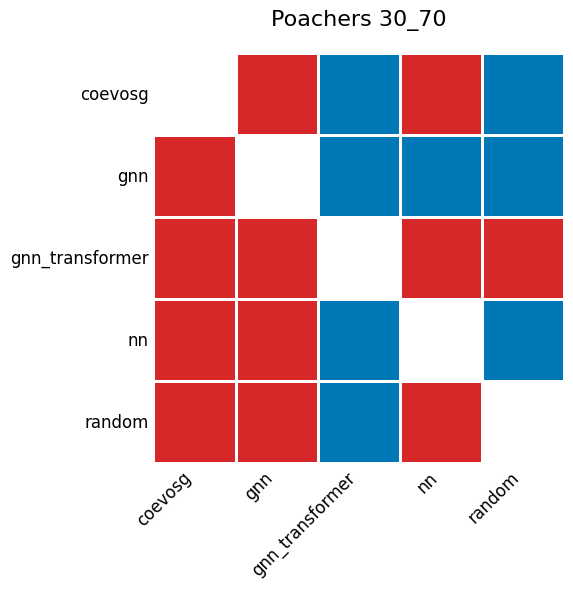

In [18]:
steps.append("30_70")
poachers_30 = read_data("stackelberg/test_poachers_30_70_41.yaml")
results = normalize(get_summarized_results_for_all_models(poachers_30, print_results=True), -39.9794, 39.9794)
values.append(results)
significance = compare_all_models(poachers_30, print_results=True)
visualize_significance(significance, 'Poachers 30_70')

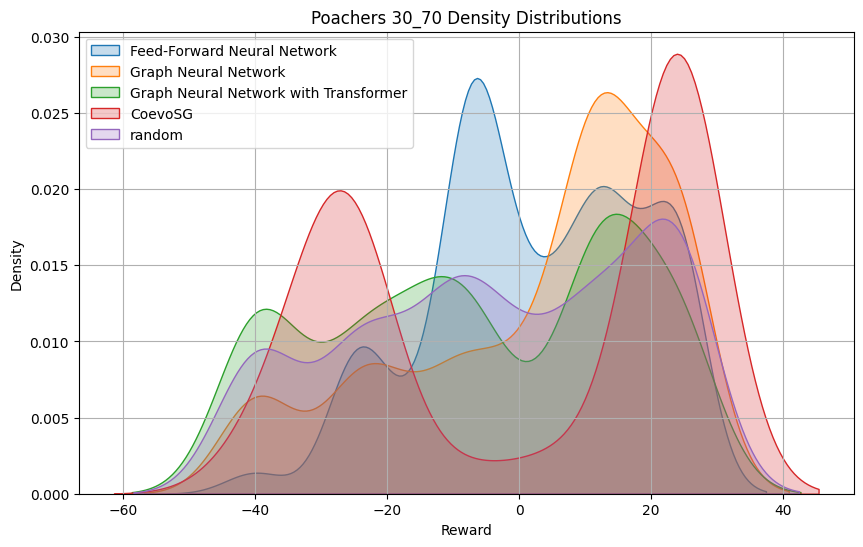

In [19]:
plot_density(poachers_30, "Poachers 30_70 Density Distributions")

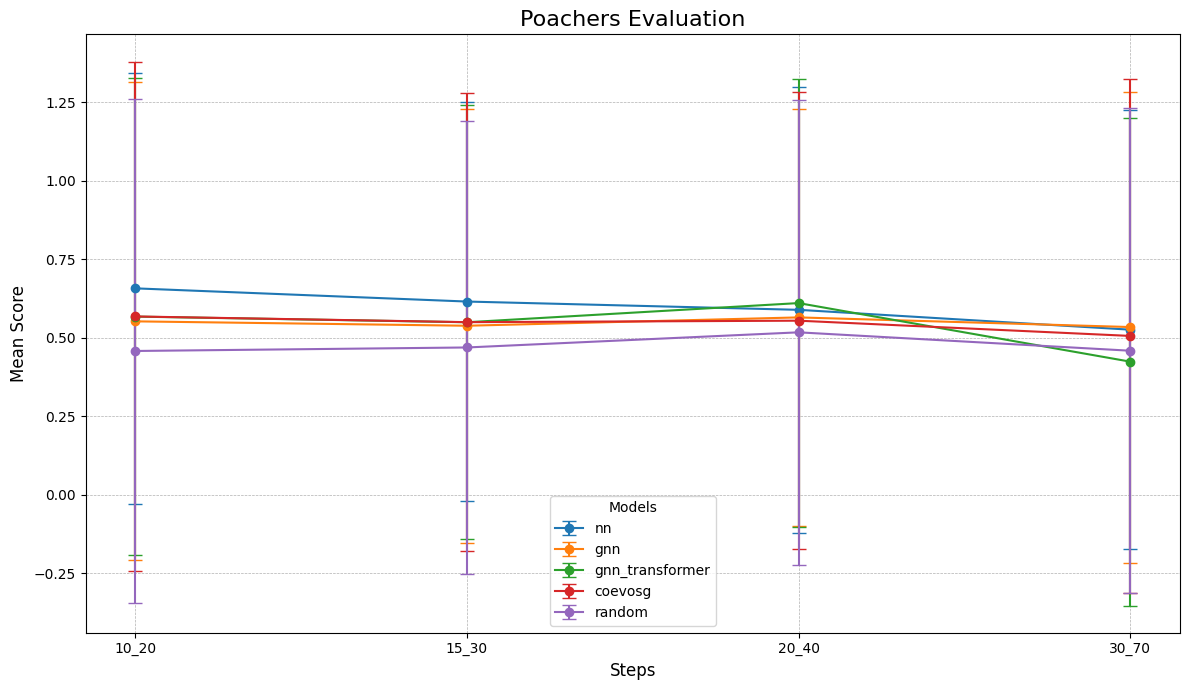

In [20]:
model_names = list(values[0].keys())
plot_data = {model: {'means': [], 'stds': []} for model in model_names}

for step_data in values:
    for model_name, stats in step_data.items():
        plot_data[model_name]['means'].append(stats['mean'])
        plot_data[model_name]['stds'].append(stats['std'])

# 3. Create the plot
fig, ax = plt.subplots(figsize=(12, 7))

# Plot each model's data using errorbar
for model_name, data in plot_data.items():
    means = np.array(data['means'])
    stds = np.array(data['stds'])
    
    # Use ax.errorbar to plot lines with vertical error bars
    ax.errorbar(
        steps,                  # X-axis values
        means,                  # Y-axis values (the mean)
        yerr=stds,              # The standard deviation for the vertical error bars
        label=model_name,       # Label for the legend
        marker='o',             # Style for the data points
        linestyle='-',          # Style for the connecting line
        capsize=5               # Adds the small horizontal bars to the error lines
    )

# 4. Customize and show the plot
ax.set_title('Poachers Evaluation', fontsize=16)
ax.set_xlabel('Steps', fontsize=12)
ax.set_ylabel('Mean Score', fontsize=12)
ax.legend(title='Models')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
# plt.ylim(bottom=0.5) # Set a reasonable y-axis minimum
plt.tight_layout()
plt.savefig('poachers.png')
plt.show()

# Police

In [30]:
values = []
steps = []

Model                          Mean       Std        N         
nn                             14.1827    11.6275    600       
gnn                            10.6039    12.5505    600       
gnn_transformer                15.9164    10.9785    600       
coevosg                        20.3931    6.4623     600       
random                         11.9226    12.5722    600       
Model                          Compared Model                 Corrected p-value    Original p-value     Significance   
nn                             gnn                            0.00000              0.00000              Significantly  
nn                             gnn_transformer                1.00000              0.99618              Not significantly
nn                             coevosg                        1.00000              1.00000              Not significantly
nn                             random                         0.00024              0.00008              Significantly  
gnn         

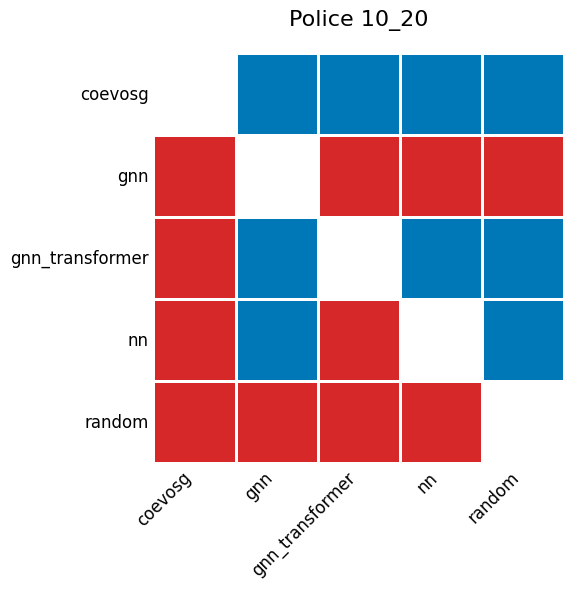

In [31]:
steps.append("10_20")
police_10 = read_data("stackelberg/test_police_10_20_41.yaml")
results = normalize(get_summarized_results_for_all_models(police_10, print_results=True), -22.4924, 22.4924)
values.append(results)
significance = compare_all_models(police_10, print_results=True)
visualize_significance(significance, "Police 10_20")

Model                          Mean       Std        N         
nn                             21.4436    16.5747    600       
gnn                            24.7965    15.9476    600       
gnn_transformer                19.5370    17.2937    600       
coevosg                        -134.1235  164.0718   600       
random                         15.7343    18.7711    600       
Model                          Compared Model                 Corrected p-value    Original p-value     Significance   
nn                             gnn                            0.99991              0.99991              Not significantly
nn                             gnn_transformer                0.01036              0.00518              Significantly  
nn                             coevosg                        0.00000              0.00000              Significantly  
nn                             random                         0.00000              0.00000              Significantly  
gnn           

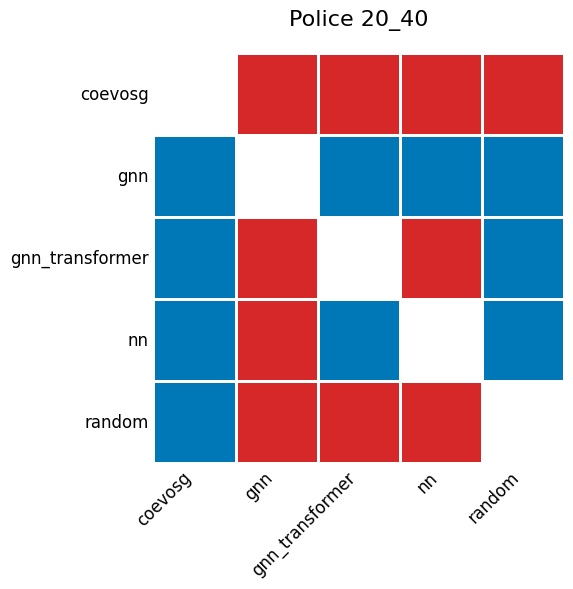

In [32]:
steps.append("20_40")
police_20 = read_data("stackelberg/test_police_20_40_41.yaml")
results = normalize(get_summarized_results_for_all_models(police_20, print_results=True), -34.1685, 34.1685)
values.append(results)
significance = compare_all_models(police_20, print_results=True)
visualize_significance(significance, "Police 20_40")

Model                          Mean       Std        N         
nn                             18.4789    19.4872    600       
gnn                            26.4163    18.1233    600       
gnn_transformer                19.7552    17.6721    600       
coevosg                        -28.4909   58.0246    600       
random                         16.4575    20.4347    600       
Model                          Compared Model                 Corrected p-value    Original p-value     Significance   
nn                             gnn                            1.00000              1.00000              Not significantly
nn                             gnn_transformer                1.00000              0.97623              Not significantly
nn                             coevosg                        0.00000              0.00000              Significantly  
nn                             random                         0.08012              0.02671              Not significantly
gnn       

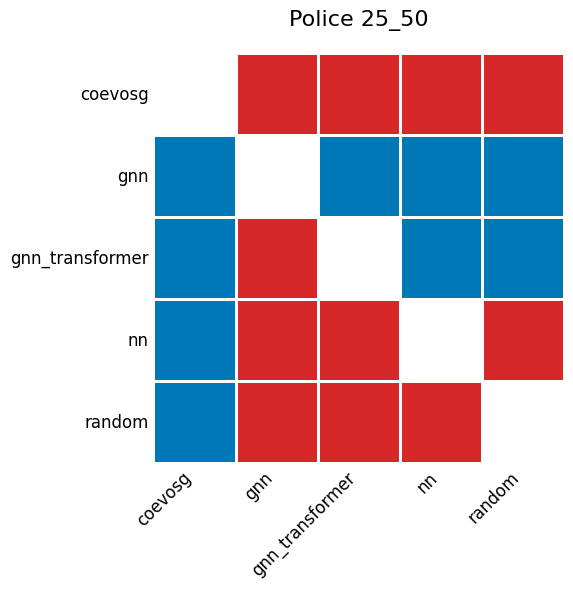

In [33]:
steps.append("25_50")
police_25 = read_data("stackelberg/test_police_25_50_41.yaml")
results = normalize(get_summarized_results_for_all_models(police_25, print_results=True), -38.3207, 38.3207)
values.append(results)
significance = compare_all_models(police_25, print_results=True)
visualize_significance(significance, "Police 25_50")

Model                          Mean       Std        N         
nn                             15.4676    21.7090    600       
gnn                            32.8002    20.5375    600       
gnn_transformer                30.0819    21.8744    600       
coevosg                        21.1844    22.4329    600       
random                         19.5775    23.1707    600       
Model                          Compared Model                 Corrected p-value    Original p-value     Significance   
nn                             gnn                            1.00000              1.00000              Not significantly
nn                             gnn_transformer                1.00000              1.00000              Not significantly
nn                             coevosg                        1.00000              1.00000              Not significantly
nn                             random                         1.00000              0.97269              Not significantly
gnn     

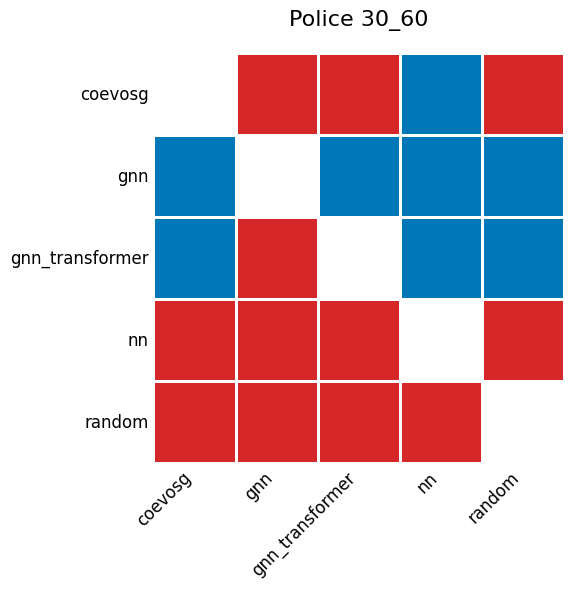

In [34]:
steps.append("30_60")
police_30 = read_data("stackelberg/test_police_30_60_41.yaml")
results = normalize(get_summarized_results_for_all_models(police_30, print_results=True), -45.9514, 45.9514)
values.append(results)
significance = compare_all_models(police_30, print_results=True)
visualize_significance(significance, "Police 30_60")

Model                          Mean       Std        N         
nn                             31.3553    35.0671    600       
gnn                            45.9304    33.4132    600       
gnn_transformer                46.8062    33.3925    600       
coevosg                        63.9057    15.3588    600       
random                         33.0568    34.9711    600       
Model                          Compared Model                 Corrected p-value    Original p-value     Significance   
nn                             gnn                            1.00000              1.00000              Not significantly
nn                             gnn_transformer                1.00000              1.00000              Not significantly
nn                             coevosg                        1.00000              1.00000              Not significantly
nn                             random                         1.00000              0.43527              Not significantly
gnn     

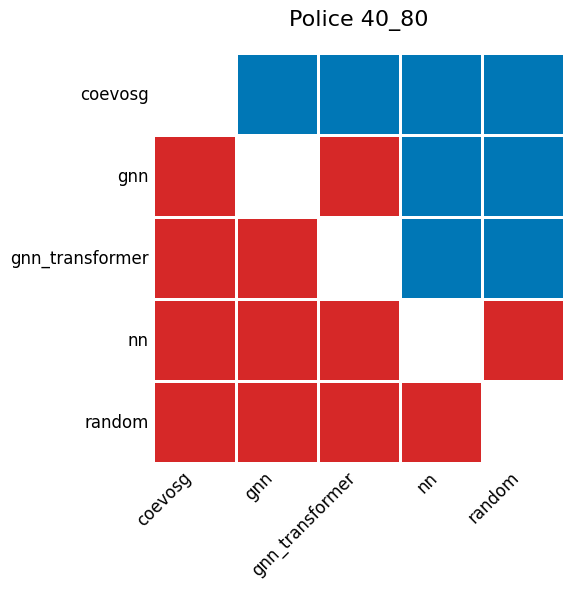

In [35]:
steps.append("40_80")
police_40 = read_data("stackelberg/test_police_40_80_41.yaml")
results = normalize(get_summarized_results_for_all_models(police_40, print_results=True), -70.6114, 70.6114)
values.append(results)
significance = compare_all_models(police_40, print_results=True)
visualize_significance(significance, "Police 40_80")

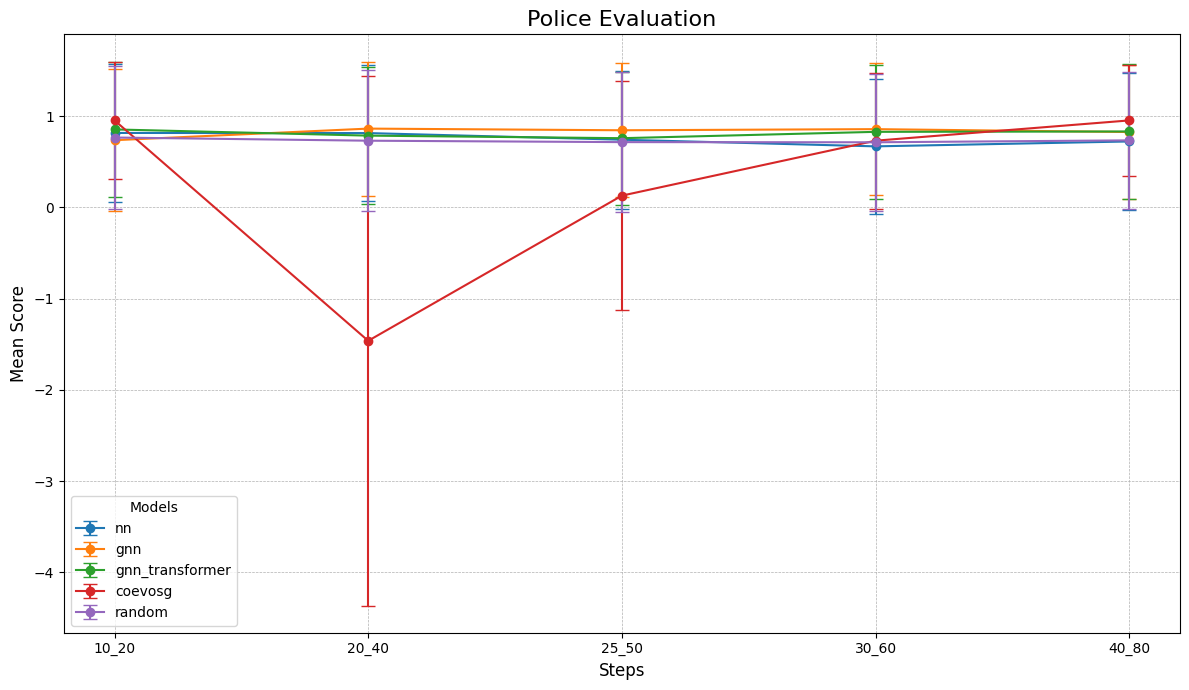

In [37]:
model_names = list(values[0].keys())
plot_data = {model: {'means': [], 'stds': []} for model in model_names}

for step_data in values:
    for model_name, stats in step_data.items():
        plot_data[model_name]['means'].append(stats['mean'])
        plot_data[model_name]['stds'].append(stats['std'])

# 3. Create the plot
fig, ax = plt.subplots(figsize=(12, 7))

# Plot each model's data using errorbar
for model_name, data in plot_data.items():
    means = np.array(data['means'])
    stds = np.array(data['stds'])
    
    # Use ax.errorbar to plot lines with vertical error bars
    ax.errorbar(
        steps,                  # X-axis values
        means,                  # Y-axis values (the mean)
        yerr=stds,              # The standard deviation for the vertical error bars
        label=model_name,       # Label for the legend
        marker='o',             # Style for the data points
        linestyle='-',          # Style for the connecting line
        capsize=5               # Adds the small horizontal bars to the error lines
    )

# 4. Customize and show the plot
ax.set_title('Police Evaluation', fontsize=16)
ax.set_xlabel('Steps', fontsize=12)
ax.set_ylabel('Mean Score', fontsize=12)
ax.legend(title='Models')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
# plt.ylim(bottom=0.5) # Set a reasonable y-axis minimum
plt.tight_layout()
plt.savefig('police.png')
plt.show()